In [1]:
# initial imports and setting up:
import os
import copy as cp
import numpy as np

import sys
# initialize stuff
if sys.platform == 'darwin':
    plat = 'usb'
    # plat = 'mac'
    sys.path.append('/Users/njchiang/GitHub/LanguageMVPA/multivariate/python/analysis')
    sys.path.append('/Users/njchiang/GitHub/python-fmri-utils/utils')
    debug = True
else:
    plat = 'win'
    sys.path.append('D:\\GitHub\\LanguageMVPA\\multivariate\\python\\analysis')
    sys.path.append('D:\\GitHub\\python-fmri-utils\\utils')
    debug = False
import lmvpautils as lmvpa
paths, subList, contrasts, maskList = lmvpa.initpaths(plat)

Initializing...


In [2]:
# set up test data (modify this)
sub = 'LMVPA005'
roi = 'left_IFG_operc'
filterLen = 49
filterOrd = 2
chunklen = 30
paramEst = .25

In [3]:
# load subject data
thisSub = {sub: subList[sub]}
mc_params = lmvpa.loadmotionparams(paths, thisSub)
beta_events = lmvpa.loadevents(paths, thisSub)
dsdict = lmvpa.loadsubdata(paths, thisSub, m=roi, c='trial_type')
thisDS = dsdict[sub]

loading LMVPA005


 * Please note: warnings are printed only once, but underlying problem might occur many times *


/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


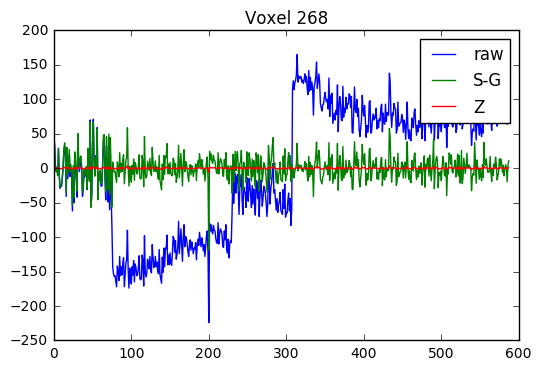

In [4]:
# # preprocess data and visualize fit
%matplotlib inline
import matplotlib.pyplot as plt
iVox = np.random.randint(0, thisDS.shape[1])
plt.plot(thisDS[:, iVox]-np.mean(thisDS[:, iVox]), label='raw')
import SavGolFilter as sg
sg.sg_filter(thisDS, filterLen, filterOrd)
plt.plot(thisDS[:, iVox], label='S-G')
from mvpa2.mappers.zscore import zscore
zscore(thisDS, chunks_attr='chunks')
plt.plot(thisDS[:, iVox], label='Z')
plt.title('Voxel ' + str(iVox))
plt.legend()
plt.show()

In [5]:
# set up design
rds, events = lmvpa.amendtimings(thisDS.copy(), beta_events[sub], contrasts)  # adding features

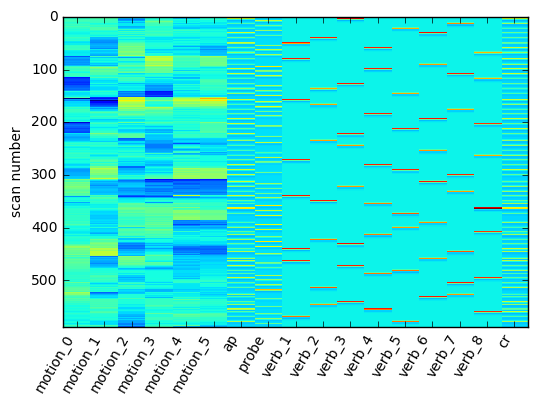

In [6]:
# encoding analysis design
thisContrast = ['ap', 'cr', 'probe', 'verb']
thisContrastStr = 'ap+cr+probe'
if isinstance(thisContrast, basestring):
    thisContrast = [thisContrast]
# instead of binarizing each one, make them parametric
hrfmodel='canonical'

import nipy.modalities.fmri.design_matrix as dm
desX, rds = lmvpa.make_designmat(rds, events, time_attr='time_coords', condition_attr=thisContrast,
                                 design_kwargs={'hrf_model': 'spm', 'drift_model': 'blank', 'drift_order': 0},
                                 regr_attrs=None)
# desX, rds = lmvpa.make_designmat(rds, events, time_attr='time_coords', condition_attr=thisContrast,
#                                  design_kwargs={'hrf_model': 'canonical', 'drift_model': 'blank', 'drift_order': 0},
#                                  regr_attrs=None)
# why does this drift?
# desX, rds = lmvpa.make_designmat(rds, events, time_attr='time_coords', condition_attr=thisContrast,
#                                  design_kwargs={'hrf_model': 'fir', 'fir_delays': [0,1,2,3], 'drift_order': 0,
#                                                 'drift_model': 'blank'},
#                                  regr_attrs=None)
# desX, rds = lmvpa.make_designmat(rds, events, time_attr='time_coords', condition_attr=thisContrast,
#                                  design_kwargs={'hrf_model': 'None', 'drift_order': 0,
#                                                 'drift_model': 'blank'},
#                                  regr_attrs=None)

# these two commands are identical
desX['motion'] = dm.make_dmtx(rds.sa['time_coords'].value, paradigm=None, add_regs=mc_params[sub], drift_model='blank')
# desX['motion'] = dm.DesignMatrix(matrix=mc_params[sub],
#                                  names=['motion_0', 'motion_1', 'motion_2', 'motion_3', 'motion_4', 'motion_5'],
#                                  frametimes=rds.sa['time_coords'].value)
des = lmvpa.make_parammat(cp.copy(desX), hrf=hrfmodel, zscore=True)
des.show()

In [7]:
#encoding
import BootstrapRidge as bsr

In [8]:
# beta extraction for searchlight
thisContrast = 'AP'
import mvpa2.datasets.eventrelated as er
evds = er.fit_event_hrf_model(rds, events, time_attr='time_coords',
                              condition_attr=('trial_type', 'chunks'),
                              design_kwargs={'add_regs': mc_params[sub], 'hrf_model': 'canonical'},
                              return_model=True)
zfds = lmvpa.replacetargets(evds, contrasts, thisContrast)
fds = lmvpa.replacetargets(evds, contrasts, thisContrast)
zscore(zfds, chunks_attr='chunks')
zfds = zfds[zfds.targets != '0']
fds = fds[fds.targets != '0']

['1' '1' '2' '2' '1' '1' '2' '2' '1' '1' '2' '2' '1' '1' '2' '2' '1' '1'
 '2' '2' '1' '1' '2' '2' '1' '1' '2' '2' '1' '1' '2' '2' '0' '0' '0' '0'
 '0' '0' '0' '0' '1' '1' '2' '2' '1' '1' '2' '2' '1' '1' '2' '2' '1' '1'
 '2' '2' '1' '1' '2' '2' '1' '1' '2' '2' '1' '1' '2' '2' '1' '1' '2' '2']


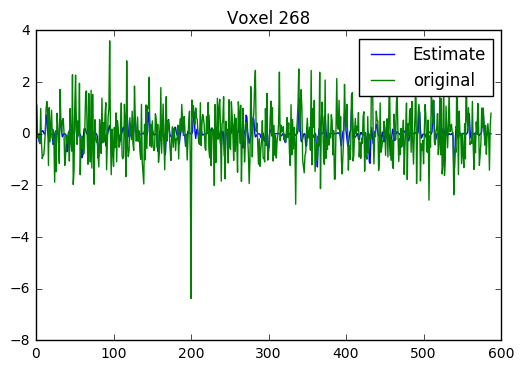

(588,)
(588, 1)


array([[ 1.        ,  0.29661875],
       [ 0.29661875,  1.        ]])

In [9]:
# beta extraction QC
print evds.sa.targets
regidx = evds.sa.targets == evds.sa.targets
# regidx = evds.sa.targets == '0'
# plt.plot(evds.sa.regressors.T[:,regidx])
plt.plot(np.dot(evds.sa.regressors.T[:, regidx], evds.samples[regidx,:])[:,iVox], label='Estimate')
plt.plot(rds.samples[:, iVox], label='original')
plt.legend()
plt.title('Voxel ' + str(iVox))
plt.show()
print np.dot(evds.sa.regressors.T[:, regidx], evds.samples[regidx,:])[:,iVox].shape
print rds[:,iVox].samples.shape
np.corrcoef(np.dot(evds.sa.regressors.T[:, regidx], evds.samples[regidx,:])[:,iVox], 
            rds.samples[:,iVox])

In [10]:
# initalize searchlight
print "searchlights"
r = 4
## initialize classifier
from mvpa2.clfs import svm
clf = svm.LinearNuSVMC()

from mvpa2.measures.base import CrossValidation
from mvpa2.generators.partition import NFoldPartitioner
cv = CrossValidation(clf, NFoldPartitioner())
from mvpa2.measures.searchlight import sphere_searchlight
cvSL = sphere_searchlight(cv, radius=r)

searchlights


In [10]:
# searchlight
# now I have betas per chunk. could just correlate the betas, or correlate the predictions for corresponding runs
lidx = fds.chunks < fds.sa['chunks'].unique[len(fds.sa['chunks'].unique) / 2]
pidx = fds.chunks >= fds.sa['chunks'].unique[len(fds.sa['chunks'].unique) / 2]

import searchlightutils as sl
lres = sl.run_cv_sl(cvSL, fds[lidx].copy(deep=False))
zlres = sl.run_cv_sl(cvSL, zfds[lidx].copy(deep=False))

# from mvpa2.base import dataset
# from mvpa2.datasets.mri import map2nifti
# map2nifti(thisDS, dataset.vstack([lres, pres])).to_filename(os.path.join(paths[0], 'Maps', 'PyMVPA', 
#                                                                          sub + '_' + roi + '_' + thisContrast + '_cvsl.nii.gz'))
# 
# del lres, pres, cvSL

running SL at 10:45:20


done in (6.900000095367432,) seconds
running SL at 10:45:27


done in (6.89900016784668,) seconds


raw: 0.544454225352| Z: 0.544454225352
difference: 0.0


C:\Python27\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


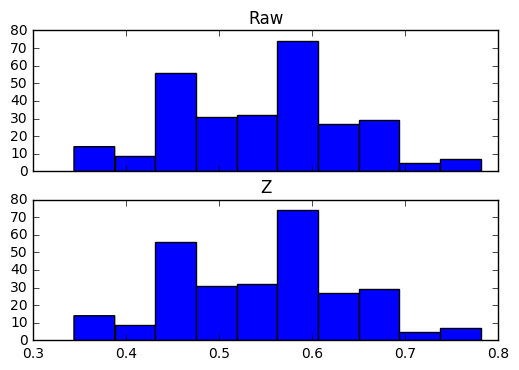

In [11]:
# compare zscored and not. It looks like as long as I zscore the raw data, there is no difference!
print 'raw: ' + str(np.mean(lres)) + '| Z: ' + str(np.mean(zlres))
print 'difference: ' + str(np.mean(lres.samples - zlres.samples))
f, axarr = plt.subplots(2, sharex=True)
axarr[0].hist(np.mean(lres, axis=0))
axarr[0].set_title('Raw')
axarr[1].hist(np.mean(zlres, axis=0))
axarr[1].set_title('Z')
f.show()